# Brazilian or European Portuguese?

This simple classifier verifies which Portuguese norm prevails in a given text.

We start by defining the problem - what question do we want to answer?<br>
In this case - is the text written in <a href="https://en.wikipedia.org/wiki/Portuguese_dialects">European or Brazilian Portuguese</a>?

In order to do it, I:
- gather data 
- prepare them for the ML algorithm
- train it and verify its accuracy
- export the trained algorithm to use it in the future.


# Gathering data

That is - what data do I need, where to gather them and how. In this case I chose TED.com as my source of data. It's a reasonably large database of lectures with a clear division between both Portuguese dialects. I scraped the lecture transcriptions using a Scrapy spider. The code for the two spiders is <a href="https://github.com/MarekCichy/pt-br-classifier/blob/master/PTCrawler.py">here</a> and <a href="https://github.com/MarekCichy/pt-br-classifier/blob/master/BRCrawler.py">here</a>.

# Data wrangling

I scraped about 2500 TED talks for each version of Portuguese, some 12-18 thousand characters per talk. After cleaning formatting (leaving only pure text), I mark the transcriptions "0" for PT-PT (European Portuguese) and "1" for PT-BR, then transform it with scikit-learn's CountVectorizer. 

CountVectorizer basically counts the number of occurences of all the words in each document. I do not use any other preprocessing. I do not stem the words, as I want to maintain the grammatical differences (e.g. verb conjugation differences) between both dialects.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics

from nltk import sent_tokenize

from joblib import dump, load

In [2]:
#importing scraped texts
pt_talks = pd.read_csv('pt_dict.csv').dropna()
br_talks = pd.read_csv('br_dict.csv').dropna()

In [3]:
pt_talks.head()

,0
Lindy Lou Isonhood,"\n\t\t\t\t\t\t\t\t\t\t\tFoi numa quarta-feira,..."
Jonathan Wilker,\n\t\t\t\t\t\t\t\t\t\t\tGostava que viessem co...
Michael C. Bush,"\n\t\t\t\t\t\t\t\t\t\t\tInterrogamos CEOs, pol..."
Rene Laufer,\n\t\t\t\t\t\t\t\t\t\t\tA mais de seis mil ano...
Kym Worthy,"\n\t\t\t\t\t\t\t\t\t\t\tEm Agosto de 2009, a m..."


In [4]:
pt_talks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2409 entries, Lindy Lou Isonhood to Stefana Broadbent
Data columns (total 1 columns):
0    2409 non-null object
dtypes: object(1)
memory usage: 37.6+ KB


In [5]:
#cleaning up
pt_talks.columns = ['text']
pt_talks.text = pt_talks.text.apply(lambda x:x.replace('\n',' '))
pt_talks.text = pt_talks.text.apply(lambda x:x.replace('\t',' '))
pt_talks['label'] = 0
pt_talks.head()

,text,label
Lindy Lou Isonhood,"Foi numa quarta-feira, ...",0
Jonathan Wilker,Gostava que viessem comigo numa vi...,0
Michael C. Bush,"Interrogamos CEOs, polícias, camio...",0
Rene Laufer,A mais de seis mil anos-luz ...,0
Kym Worthy,"Em Agosto de 2009, a minha procura...",0


In [6]:
br_talks.columns = ['text']
br_talks.text = br_talks.text.apply(lambda x:x.replace('\t',' '))
br_talks.text = br_talks.text.apply(lambda x:x.replace('\n',' '))
br_talks['label'] = 1
br_talks.head()

,text,label
Stacie Bosley,"Em 2004, uma nova empre...",1
César Hidalgo,Sou só eu ou há outras ...,1
Sarah Barmak,"Em nossa cultura, tendemos a ver o...",1
Shohini Ghose,Se quisesse dar apenas uma olhadin...,1
Balsher Singh Sidhu,"Olhando do espaço, nosso planeta p...",1


In [7]:
br_talks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2897 entries, Stacie Bosley to José Antonio Abreu
Data columns (total 2 columns):
text     2897 non-null object
label    2897 non-null int64
dtypes: int64(1), object(1)
memory usage: 67.9+ KB


In [8]:
#making a joint DF
joint_df = pd.concat([br_talks, pt_talks])
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5306 entries, Stacie Bosley to Stefana Broadbent
Data columns (total 2 columns):
text     5306 non-null object
label    5306 non-null int64
dtypes: int64(1), object(1)
memory usage: 124.4+ KB


In [9]:
joint_df.head()

,text,label
Stacie Bosley,"Em 2004, uma nova empre...",1
César Hidalgo,Sou só eu ou há outras ...,1
Sarah Barmak,"Em nossa cultura, tendemos a ver o...",1
Shohini Ghose,Se quisesse dar apenas uma olhadin...,1
Balsher Singh Sidhu,"Olhando do espaço, nosso planeta p...",1


In [10]:
vectorizer = CountVectorizer(min_df=2)

In [11]:
y = joint_df.label
X_train, X_test, y_train, y_test = train_test_split(joint_df['text'], y, test_size=0.33, random_state=53)
train = vectorizer.fit_transform(X_train.values)


# Training

Unsurprisingly, I split the texts into a training and testing sets and train a MultinomialNaiveBayes model on these. The model basically checks the frequency of a given word in the BR and PT sets and thus determines if the word suggests a more "Brazilian" or "Portuguese" word. All of the words in a phrase are weighed and the final probability is given.

I transform the test set - I want to be able to classify short texts, of, say, 4 sentences. Thus, I split the test set texts into smaller ones. Let's see how it reflects on the classifier's precision.

In [12]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
test_tokenized = X_test.apply(lambda x: sent_tokenize(x))
spread = test_tokenized.apply(pd.Series)
spread = spread.fillna('')
for y in range(0,340,4):
    spread['grouped'+str(y/4)] = spread.iloc[:,y:y+4].apply(lambda x: ' '.join(x), axis=1)
spread = spread.loc[:,'grouped0.0':]
spread['label'] = y_test
test_df = spread.melt(id_vars='label')
test_df['len'] = test_df.value.apply(lambda x: len(x))
test_df = test_df[test_df.len > 30]

In [14]:
test = vectorizer.transform(test_df.value)

In [15]:
pred = nb_classifier.predict(test)
score = metrics.accuracy_score(test_df.label, pred)
score

0.8654743849835536

In [16]:
cm = metrics.confusion_matrix(test_df.label, pred, labels = [0,1])
cm

array([[18393,  3450],
       [ 3380, 25548]], dtype=int64)

# Result

Not bad! A simple method and a dataset smaller than the whole Wikipedia gave 86,47% accuracy for short texts, 4 sentences long. These are, naturally, samples from the same source as the test set. In the future I want to check the classifier's performance in other genres.

For the time being, let's print out some incorrect classification examples.

In [17]:
check_falses = test_df.reset_index()
check_falses['pred'] = pred

falses = check_falses[check_falses['label'] != check_falses['pred']]
falses.values[:5]

array([[0, 0, 'grouped0.0',
        '            As coisas que fazemos            têm uma qualidade suprema —            elas vivem mais tempo do que nós. Nós perecemos, elas sobrevivem;            nós temos uma vida, elas têm muitas vidas,            e em cada vida elas podem significar coisas diferentes. O que significa que, enquanto nós todos temos uma biografia,            elas têm muitas. Eu quero falar esta manhã            acerca da história, a biografia — ou antes, as biografias —            de um objeto em particular,            uma coisa notável.',
        525, 1],
       [4, 1, 'grouped0.0',
        '            Não seria ótimo se pudéssemos ser            invisíveis? Ah, não acha? Quero dizer, poderíamos espiar as pessoas sem sermos notados            e fazer qualquer coisa que quiséssemos            sem sermos responsabilizados. Bom, os mágicos descobriram            como utilizar espelhos em tamanho natural para curvar a luz,            a fim de criar a ilusão de que cois

# Classifier comparison

How would logistic regression fare on the same problem? Were my tutors right in recommending NaiveBayes?

In [18]:
lr = LogisticRegression()
lr.fit(train, y_train)
lr.score(train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.99915611814346

In [19]:
lr.score(test, test_df.label)

0.7444998128853085

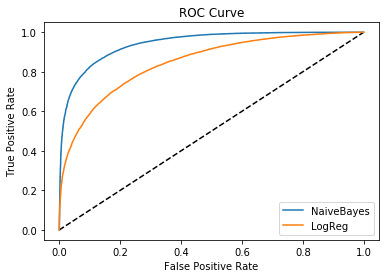

In [23]:
y_nb_pred_prob = nb_classifier.predict_proba(test)[:,1]
y_lr_pred_prob = lr.predict_proba(test)[:,1]

nb_fpr, nb_tpr, nb_thresholds = metrics.roc_curve(test_df.label, y_nb_pred_prob)
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(test_df.label, y_lr_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(nb_fpr, nb_tpr, label='NaiveBayes')
plt.plot(lr_fpr, lr_tpr, label='LogReg')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right') 
plt.show()

# Export

The original method is clearly superior to logistic regression. 
In the last step, I export the data (word counts and NaiveBayes weights) into a JSON format and the model itself into a Joblib format in order to use it externally, e.g. on a <a href="http://marekcichy.alwaysdata.net">Web page</a>.

In [24]:
json_df = pd.DataFrame([vectorizer.inverse_transform(nb_classifier.coef_)[0], 
                        nb_classifier.feature_count_[0], nb_classifier.feature_count_[1], 
                        nb_classifier.feature_log_prob_[0], nb_classifier.feature_log_prob_[1]])

json_df = json_df.T

json_df.columns = ['word', 'pt_count', 'br_count', 'pt_log_prob', 'br_log_prob']
json_df = json_df.set_index('word')

In [25]:
json_dict = json_df.to_dict()

In [26]:
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(json_dict, f, ensure_ascii=False, indent=4)

In [27]:
pipeline = Pipeline([('vectorizer',vectorizer),('classifier',nb_classifier)])

dump(pipeline, 'ptclassifier.joblib', protocol = 2) 

['ptclassifier.joblib']